In [6]:

#%% 0. Housekeeping

# =============================================================================
# 0.1 Import packages
# =============================================================================

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import seaborn as sns
# =============================================================================
# 0.2 Import data
# =============================================================================
if __name__ == '__main__':
    train = pd.read_csv('data/train.csv', low_memory=False)
    store = pd.read_csv('data/store.csv', low_memory=False)

    #%% 1. Merging store to train data

    # =============================================================================
    # 1.1 Since data has to have the same size as 'train', a container is created
    # =============================================================================

    # Creating dataframe
    expanded_store = train

    # =============================================================================
    # 1.2 Merging variables which do not have to be changed
    # =============================================================================

    # Variables which can be merged right away
    easy = store.loc[:,['Store','StoreType','Assortment','CompetitionDistance']]

    # Variables which can be simply merged
    expanded_store = pd.merge(expanded_store, easy, on=['Store'])

    #%% 2. Creating a dummy variable since for competition is open for every store

    # =============================================================================
    # 2.1 Checking whether there is actually competition
    # =============================================================================

    # Dataset of the variables which have to be transformed
    competition = store.loc[:,['Store',
                               'CompetitionOpenSinceMonth','CompetitionOpenSinceYear']]

    # For easier looping
    competition.set_index('Store', inplace=True)

    # Finding stores which have competition openend
    open_comp = competition.any(axis=1)

    # Stores with competition
    open_stores = competition.loc[open_comp].index.unique()

    # =============================================================================
    # 2.2 Generating dummy for the time competition is existing
    # =============================================================================

    # Generating Date when opened
    for store_id in open_stores:
        year = competition.loc[store_id,'CompetitionOpenSinceYear'].astype(int)
        month = competition.loc[store_id,'CompetitionOpenSinceMonth'].astype(int)
        competition.loc[store_id,'CompetitionDate'] = datetime(year,month,1)

    # Creating a dummy variable for whether competition openend for each store
    expanded_store.loc[:,'CompetitionOpened'] = 0

    for store_id in open_stores:

        # Getting the date when competition openend
        date = competition.loc[store_id,'CompetitionDate']
        date_str= date.strftime("%Y-%m-%d")

        store_number = expanded_store.loc[:,'Store'] == store_id

        maximum_date = expanded_store.loc[store_number,'Date'].max()

        # Whether it falls in time frame
        competition_existing = (expanded_store.loc[:,'Date'].between(date_str,maximum_date)) &  (expanded_store.loc[:,'Store'] == store_id)

        # Indicating whether competition is around
        expanded_store.loc[competition_existing, 'CompetitionOpened'] = 1


    #%% 3. Creating a dummy variable for Promo

    # =============================================================================
    # 3.1 Since data has to have the same size as 'train', a container is created
    # =============================================================================

    # Create dataframe
    promo2 = store.loc[:,['Store',
                         'Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']]

    # =============================================================================
    # 3.2 Create dummy for whether a promo2 is running
    # =============================================================================

    # Getting date from which promo started
    length = promo2.shape[0]
    for i in range(length):
        if promo2.loc[i,'Promo2']:
            week = promo2.loc[i,'Promo2SinceWeek'].astype(int)
            year = promo2.loc[i,'Promo2SinceYear'].astype(int)
            promo2.loc[i,'promo2start'] = dt.datetime.strptime(f'{year}-W{int(week )- 1}-1', "%Y-W%W-%w").date()

    # Merge it with the train file
    expanded_promo = pd.merge(expanded_store, promo2, on=['Store'])


    # Empty container with no promo indicator
    expanded_promo.loc[:,'Promo2GoingOn'] = 0

    # Month indication
    expanded_promo.loc[:,'Date_str'] = pd.to_datetime(expanded_promo.loc[:,'Date'],).dt.strftime('%Y-%b-%d')
    expanded_promo.loc[:,'Date'] = pd.to_datetime(expanded_promo.loc[:,'Date'],)
    expanded_promo.loc[:,'month'] = expanded_promo.loc[:,'Date_str'].str[5:8]


    months = expanded_promo.loc[:,'month'].unique()

    for month in months:
        month_boolean = expanded_promo.loc[:,'PromoInterval'].str.contains(month, na=False)
        expanded_promo.loc[month_boolean,'Promo2GoingOn'] = 1


    #%% 4. Creating time since competition opened

    exp_comp = pd.merge(expanded_promo, competition, on=['Store'])

    date_current = pd.to_datetime(exp_comp.loc[:,'Date'])
    date_openend = pd.to_datetime(exp_comp.loc[:,'CompetitionDate'])

    exp_comp.loc[:,'comp_open_since'] = (date_current - date_openend).astype('timedelta64[D]')

    future_comp = (exp_comp.loc[:,'comp_open_since'] < 0)
    no_comp = exp_comp.loc[:,'comp_open_since'].isna()

    exp_comp.loc[future_comp, 'comp_open_since'] = 0
    exp_comp.loc[no_comp, 'comp_open_since'] = 0

    expanded_promo.loc[:,'comp_open_since'] = exp_comp.loc[:,'comp_open_since']

    #%% 5. Decaying competition factor

    expanded_promo.loc[:,'IntervalList'] = expanded_promo.loc[:,'PromoInterval'].str.split(pat = ',')

    Interval = {'First': 0,
    'Second' : 1,
    'Third' : 2,
    'Fourth': 3}

    for element, value in Interval.items():
        expanded_promo.loc[:,element] = expanded_promo.loc[:,'IntervalList'].str[value]

    year = pd.to_datetime(expanded_promo.loc[:,'Date']).dt.year.astype(str)

    Interval = {'Interval1': 'First',
    'Interval2' : 'Second',
    'Interval3' : 'Third',
    'Interval4': 'Fourth'}

    expanded_promo.loc[:,'Date_Actual'] = pd.to_datetime(expanded_promo.loc[:,'Date'])

    for element, value in Interval.items():

        ### New year stuff
        expanded_promo.loc[:,'Date_Str'] = '1' + '-' + expanded_promo.loc[:,value] + '-' + year
        dates = pd.to_datetime(expanded_promo.loc[:,'Date_Str'])

        expanded_promo.loc[:,element] = (expanded_promo.loc[:,'Date_Actual'] - dates).astype('timedelta64[D]')

        negative = expanded_promo.loc[:,element] < 0
        expanded_promo.loc[negative,element] = np.nan

        ### Last year stuff
        expanded_promo.loc[:,'Date_Str'] = '1' + '-' + expanded_promo.loc[:,value] + '-' + (year.astype(int)-1).astype(str)
        dates = pd.to_datetime(expanded_promo.loc[:,'Date_Str'])

        expanded_promo.loc[:,element + 'before'] = (expanded_promo.loc[:,'Date_Actual'] - dates).astype('timedelta64[D]')

        negative = expanded_promo.loc[:,element + 'before'] < 0
        expanded_promo.loc[negative,element + 'before'] = np.nan

    all_versions = expanded_promo.loc[:,['Interval1','Interval2','Interval3','Interval4',
    'Interval1before','Interval2before','Interval3before','Interval4before',]]
    minimum_distance = all_versions.min(axis=1, skipna=True)

    expanded_promo.loc[:,'DaysFromPromotion'] = minimum_distance

    expanded_promo.loc[:,'Decay'] = np.exp(- 0.05 * minimum_distance)

    expanded_promo=expanded_promo[['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpened', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'Promo2GoingOn', 'comp_open_since', 'DaysFromPromotion','Decay']]
    expanded=expanded_promo.copy()
    expanded_promo.info()

    # Convert Dates to Date time
    expanded=expanded_promo.copy()

    expanded['Date']=pd.to_datetime(expanded['Date'])

    #add in variables for day of month etc
    expanded['dayofweek'] = expanded['Date'].dt.dayofweek
    expanded['quarter'] = expanded['Date'].dt.quarter
    expanded['month'] = expanded['Date'].dt.month
    expanded['year'] = expanded['Date'].dt.year
    expanded['dayofyear'] = expanded['Date'].dt.dayofyear
    expanded['dayofmonth'] = expanded['Date'].dt.day
    expanded['weekofyear'] = expanded['Date'].dt.weekofyear

    #create dummy variables for day of week etc and categorical variables

    expanded= pd.get_dummies(expanded,columns=['dayofweek','dayofmonth','quarter','month','StateHoliday','StoreType','Assortment'])

    #Re-add original day of month variable etc.
    expanded['dayofweek'] = expanded['Date'].dt.dayofweek
    expanded['quarter'] = expanded['Date'].dt.quarter
    expanded['month'] = expanded['Date'].dt.month
    expanded['year'] = expanded['Date'].dt.year
    expanded['dayofyear'] = expanded['Date'].dt.dayofyear
    expanded['dayofmonth'] = expanded['Date'].dt.day
    expanded['weekofyear'] = expanded['Date'].dt.weekofyear

    expanded.dropna(axis = 0, how ='any',inplace=True)
    expanded=expanded[expanded['Sales'] >0 ]

    print(expanded.shape)

    from datetime import timedelta
    import datetime
    df=expanded.copy()
    date_range_days=(df['Date'].max() - df['Date'].min()).days
    split_date=df['Date'].min() + timedelta(date_range_days*0.8) #train set 80% of full population
    #randomly creating train and test subsets. may need to refine this
    df_early,df_later = df.loc[df['Date'] <= split_date], df.loc[df['Date'] > split_date]
    print(df.shape)
    aggs=df_early.groupby(by=['Store']).agg({'Sales':'sum','Customers':'sum'})
    aggs['av_SalesPerCustomer']=aggs['Sales']/aggs['Customers']
    aggs.sort_values(by='av_SalesPerCustomer',ascending=False)
    df_early= pd.merge(df_early, aggs['av_SalesPerCustomer'], on=['Store'])
    df_later= pd.merge(df_later, aggs['av_SalesPerCustomer'], on=['Store'])
    df= pd.merge(df, aggs['av_SalesPerCustomer'], on=['Store'])
    #create sales per customer for each store and day
    #expanded['SalesPerCustomer']=expanded['Sales']/expanded['Customers']
    print(df.shape)
    #create av sales per day of the week
    aggs_1=df_early.groupby(by=['Store','dayofweek']).agg({'Sales':'sum','Customers':'sum'})
    aggs_1['av_SalesPerCustomer_dayofweek']=aggs_1['Sales']/aggs_1['Customers']
    aggs_1.sort_values(by='av_SalesPerCustomer_dayofweek',ascending=False)
    #df_early= pd.merge(df_early, aggs['av_SalesPerCustomer_dayofweek'], on=['Store'])
    #df_later= pd.merge(df_later, aggs['av_SalesPerCustomer_dayofweek'], on=['Store'])
    df= pd.merge(df, aggs_1['av_SalesPerCustomer_dayofweek'], on=['Store','dayofweek'])
    #create sales per customer for each store and day
    #expanded['SalesPerCustomer']=expanded['Sales']/expanded['Customers']


    aggs=df_early.groupby(by=['Store','dayofmonth']).agg({'Sales':'sum','Customers':'sum'})
    aggs['av_SalesPerCustomer_dayofmonth']=aggs['Sales']/aggs['Customers']
    aggs.sort_values(by='av_SalesPerCustomer_dayofmonth',ascending=False)
    #df_early= pd.merge(df_early, aggs['av_SalesPerCustomer_dayofmonth'], on=['Store'])
    #df_later= pd.merge(df_later, aggs['av_SalesPerCustomer_dayofmonth'], on=['Store'])
    df= pd.merge(df, aggs['av_SalesPerCustomer_dayofmonth'], on=['Store','dayofmonth'])
    #create sales per customer for each store and day
    #expanded['SalesPerCustomer']=expanded['Sales']/expanded['Customers']

    df.set_index('Date', inplace=True)
    print(df.shape)



    ######
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    import xgboost as xgb
    from xgboost import plot_importance
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split as train_test_split
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.width', 1000)
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    from datetime import timedelta
    import datetime
    from bayes_opt import BayesianOptimization



    cols = list(df.columns.values) #Make a list of all of the columns in the df
    cols.pop(cols.index('Sales')) #Remove sales from list
    df = df[cols + ['Sales']] #Create new dataframe with sales right at the end
    X, y = df.iloc[:, :-1],df.iloc[:, -1]
    df=df[['av_SalesPerCustomer','av_SalesPerCustomer_dayofweek',
                               'av_SalesPerCustomer_dayofmonth','Customers',
           'Promo','Promo2','CompetitionDistance','dayofweek','Decay','comp_open_since','Sales']]

    date_range_days=(df.index.max() - df.index.min()).days
    split_date=df.index.min() + timedelta(date_range_days*0.8) #train set 80% of full population
    #randomly creating train and test subsets. may need to refine this
    df_early,df_later = df.loc[df.index <= split_date], df.loc[df.index > split_date]
    #create feature matrix of everything up to sales, create labels from sales
    X_train, X_test, y_train, y_test = df_early.iloc[:,:-1], df_later.iloc[:,:-1], df_early.iloc[:,-1], df_later.iloc[:,-1]



    # creating XGB optimised data structure. we will need this for our cross validation model later
    df_DM = xgb.DMatrix(data=X, label=y)

    #here we decide the parameters that we are going to use in the model
    params = {"objective":"reg:squarederror", #type of regressor, shouldnt change
              'colsample_bytree': 0.627, #percentage of features used per tree. High value can lead to overfitting.
              'learning_rate': 0.1, #step size shrinkage used to prevent overfitting. Range is [0,1]
              'max_depth': 5, #determines how deeply each tree is allowed to grow during any boosting round. keep this low! this will blow up our variance if high
              'lambda': 4.655, #L1 regularization on leaf weights. A large valupythone leads to more regularization. Could consider l2 euclidiean regularisation
              'n_estimators': 1250, #number of trees you want to build.
              'n_jobs': 4,#should optimise core usage on pc
             'subsample':0.86}

    #now we must instantiate the XGB regressor by calling XGB regressor CLASS from the XGBoost library, we must give it the hypter parameters as arguments
    xg_reg = xgb.XGBRegressor(**params)
    #Fit the regressor to the training set and make predictions for the test set using .fit() and .predict() methods
    xg_reg.fit(X_train, y_train)
    preds = xg_reg.predict(X_test)
    preds_train = xg_reg.predict(X_train)

    EPSILON = 1e-10
    def _error(actual: np.ndarray, predicted: np.ndarray):
        """ Simple error """
        return actual - predicted
    def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
        """
        Percentage error
        Note: result is NOT multiplied by 100
        """
        return _error(actual, predicted) / (actual + EPSILON)

    def rmspe(actual: np.ndarray, predicted: np.ndarray):

        return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))

    #now we must instantiate the XGB regressor by calling XGB regressor CLASS from the XGBoost library, we must give it the hypter parameters as arguments
    xg_reg = xgb.XGBRegressor(**params)

    #Fit the regressor to the training set and make predictions for the test set using .fit() and .predict() methods
    xg_reg.fit(X_train, y_train)
    test_preds = xg_reg.predict(X_test)
    train_preds = xg_reg.predict(X_train)
    print("RMSE train: %f" % np.sqrt(mean_squared_error(y_train, train_preds)))
    print("RMSE test: %f" % np.sqrt(mean_squared_error(y_test, test_preds)))

    print("RMSPE (test): %f" % (rmspe(y_test,preds)*100) +'%')
    print("RMSPE (train): %f" % (rmspe(y_train,preds_train)*100) +'%')
    print(np.sqrt(mean_squared_error(y_test, preds)))
    #logger.append(X_train.columns)
    #logger.append(rmspe(y_test,preds)*100)

     #bayesian optimisation of hyper parameters
    def xgb_evaluate(max_depth, lambd, colsample_bytree,subsample):
        params1 = {'objective': 'reg:squarederror',
                  'max_depth': int(max_depth),
                  'learning_rate': 0.1,
                  'lambda': lambd,
                   'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'n_jobs': 4}
        # Used around 1000 boosting rounds in the full model
        cv_result = xgb.cv(dtrain=df_DM, params=params1, num_boost_round=125, nfold=3,metrics='rmse',seed=42)    

        # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
        return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

    xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (3, 5), 
                                                 'lambd': (2, 6),
                                                 'colsample_bytree': (0.3, 0.8),
                                                'subsample': (0.8,1)})
    # Use the expected improvement acquisition function to handle negative numbers
    # Optimally needs quite a few more initiation points and number of iterations
    xgb_bo.maximize(init_points=10, n_iter=3, acq='ei')
    #extract best parameters from model
    params1 = xgb_bo.max['params']
    print (params1)
    #Converting the max_depth and from float to int
    params1['max_depth']= int(params1['max_depth'])
    
    xg_reg2 = xgb.XGBRegressor(**params1,n_estimators=500)
    xg_reg2.fit(X_train, y_train)
    train_preds1 = xg_reg2.predict(X_train)
    test_preds1 = xg_reg2.predict(X_test)
    print("RMSE train: %f" % np.sqrt(mean_squared_error(y_train, train_preds1)))
    print("RMSE test: %f" % np.sqrt(mean_squared_error(y_test, test_preds1)))
    print("RMSPE (test): %f" % (rmspe(y_test,test_preds1)*100) +'%')
    print("RMSPE (train): %f" % (rmspe(y_train,train_preds1)*100) +'%')
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618473 entries, 0 to 618472
Data columns (total 20 columns):
Date                   618473 non-null datetime64[ns]
Store                  618473 non-null float64
DayOfWeek              600036 non-null float64
Sales                  600028 non-null float64
Customers              599957 non-null float64
Open                   599832 non-null float64
Promo                  599791 non-null float64
StateHoliday           599873 non-null object
SchoolHoliday          599686 non-null float64
StoreType              618473 non-null object
Assortment             618473 non-null object
CompetitionDistance    616838 non-null float64
CompetitionOpened      618473 non-null int64
Promo2                 618473 non-null int64
Promo2SinceWeek        314828 non-null float64
Promo2SinceYear        314828 non-null float64
Promo2GoingOn          618473 non-null int64
comp_open_since        618473 non-null float64
DaysFromPromotion      314828 non-null float6

ModuleNotFoundError: No module named 'bayes_opt'

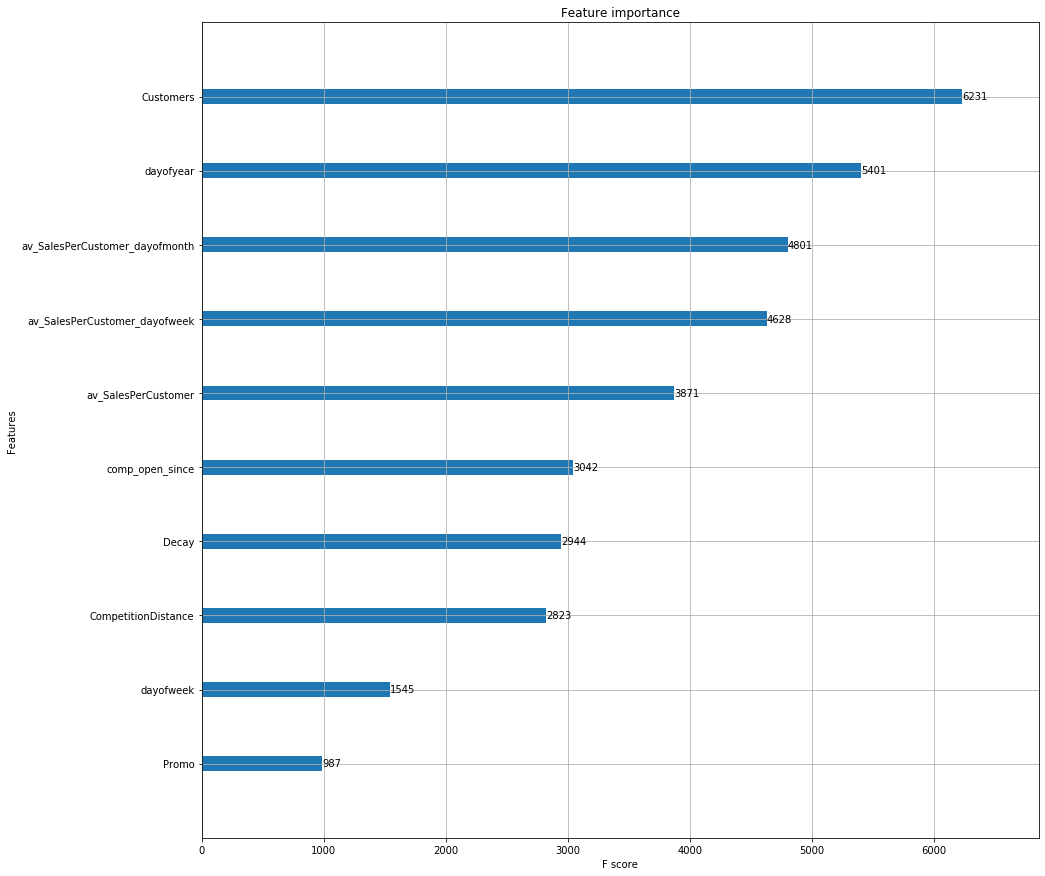

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_importance(xg_reg, ax=ax)

In [10]:
!pip install bayesopt

  ERROR: Could not find a version that satisfies the requirement bayesopt (from versions: none)
ERROR: No matching distribution found for bayesopt
